In [1]:
import pickle
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.6)
from matplotlib.colors import LogNorm

# Change here!
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_new_6"
fpath2 = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_predictors"
output_fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_new_6/cleaned_results"

In [2]:
m_dict = {'lr': 'Logit', 'ols': 'OLS',
          'rf': 'RF', 'xgb': 'XGBoost',
          'cox': 'CoxPH'}
pred_dict = {}
for m in ['lr','ols','cox','rf','xgb']:
    pred_dict[m_dict[m]] = list(pickle.load(open(fpath + "/y_test_pred_{}.p".format(m), 'rb')))
pred_dict_2 = {}
base_pred = pd.read_csv(fpath2 + "/cleaned_results/all_pred_scores.csv")
for m in base_pred.columns.values[1:]:
    pred_dict_2[m] = list(base_pred[m])
pred_dict_2['CoxPH'] = list(pickle.load(open("C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/y_test_pred_cox.p", "rb")))

In [3]:
pred_pctile_dict = {}
for m in ['OLS','Logit','CoxPH','RF','XGBoost']:
    pred_pctile_dict[m] = \
    pd.cut(pred_dict[m], [-math.inf] + list(np.quantile(pred_dict[m], q=np.linspace(0.01,0.99,99))) + [math.inf],
           labels = range(100,0,-1)).astype(int)
pred_pctile_dict_2 = {}
for m in ['OLS','Logit','CoxPH','RF','XGBoost']:
    pred_pctile_dict_2[m] = \
    pd.cut(pred_dict_2[m], [-math.inf] + list(np.quantile(pred_dict_2[m], q=np.linspace(0.01,0.99,99))) + [math.inf],
           labels = range(100,0,-1)).astype(int)

#### Generate Appendix Figure A12

In [4]:
m_list = ['OLS','Logit','CoxPH','RF','XGBoost']
r = []
for i1,m in enumerate(m_list):
    g1 = pred_pctile_dict_2[m]
    g2 = pred_pctile_dict[m]
    g_diff = np.abs(np.array(g1) - np.array(g2))
    r.append((m,
              sum(np.array(g_diff>=0) & np.array(g_diff<=5))/len(g_diff),
              sum(np.array(g_diff>5) & np.array(g_diff<=10))/len(g_diff), 
              sum(np.array(g_diff>10) & np.array(g_diff<=15))/len(g_diff),
              sum(np.array(g_diff>15) & np.array(g_diff<=20))/len(g_diff),
              sum(g_diff>20)/len(g_diff)))
r_df = pd.DataFrame(r, columns=['Model', 'Move_0-5_percentiles',
                                'Move_6-10_percentiles', 'Move_11-15_percentiles', 
                                'Move_16-20_percentiles', 'Move_21_or_more_percentiles'])
r_df = r_df.round(4)
r_df.to_csv(output_fpath + "/pred_score_comparison/updated/percentile_change_1_new.csv", index=False)
print(r_df)

     Model  Move_0-5_percentiles  Move_6-10_percentiles  \
0      OLS                0.3948                 0.2463   
1    Logit                0.4509                 0.2455   
2    CoxPH                0.5275                 0.2401   
3       RF                0.5579                 0.2757   
4  XGBoost                0.6182                 0.2389   

   Move_11-15_percentiles  Move_16-20_percentiles  Move_21_or_more_percentiles  
0                  0.1604                  0.0938                       0.1048  
1                  0.1448                  0.0776                       0.0812  
2                  0.1257                  0.0611                       0.0456  
3                  0.1169                  0.0364                       0.0131  
4                  0.0929                  0.0326                       0.0174  


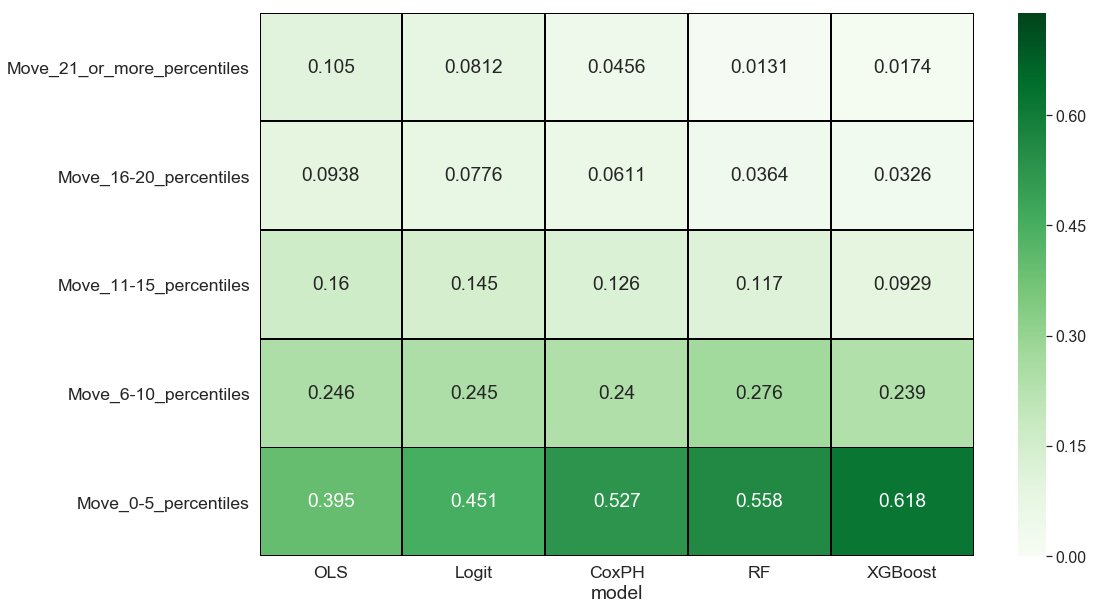

In [5]:
col_labels = list(r_df.iloc[:,0])
row_labels = ['Move_21_or_more_percentiles', 'Move_16-20_percentiles', 'Move_11-15_percentiles', 
              'Move_6-10_percentiles', 'Move_0-5_percentiles']
new_r_df = pd.DataFrame(r_df.iloc[:,1:].get_values().T[range(4,-1,-1),:], columns=col_labels, index=row_labels)
vmin = r_df.iloc[:,1:].get_values().min().min()
vmax = r_df.iloc[:,1:].get_values().max().max()
l = vmax - vmin
plt.figure(figsize=(16,10))
g = sns.heatmap(new_r_df,annot=True,fmt=".3g",cmap="Greens",vmin=max(0,vmin-0.2*l),vmax=min(1,vmax+0.2*l),
                linewidths=1, linecolor='black')
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xlabel("model")
plt.savefig(output_fpath+"/pred_score_comparison/updated/percentile_change_1_heatmap_new.png", bbox_inches="tight")
plt.show()

#### Generate Appendix Figure A13

In [6]:
top_ind = 0
stuid_list = {}
for q in [0.1,0.3,0.5]:
    for i,m in enumerate(m_list):
        g = [(e1,e2) for e1,e2 in zip(base_pred.iloc[:,0], pred_dict_2[m])]
        l = len(pred_dict_2[m])
        l1 = int(round(l*(q-0.1)))
        l2 = int(round(l*q))
        if top_ind == 0:
            new_t = sorted(g, key=lambda x:x[1])
        else:
            new_t = sorted(g, key=lambda x:-x[1])
        stuid = [e[0] for e in new_t[l1:l2]]
        stuid_list[(m,q)] = stuid[:]
        # common = np.zeros((4,4))

In [7]:
top_ind = 0
stuid_list_2 = {}
for q in [0.1,0.3,0.5]:
    for i,m in enumerate(m_list):
        g = [(e1,e2) for e1,e2 in zip(base_pred.iloc[:,0], pred_dict[m])]
        l = len(pred_dict[m])
        l1 = int(round(l*(q-0.1)))
        l2 = int(round(l*q))
        if top_ind == 0:
            new_t = sorted(g, key=lambda x:x[1])
        else:
            new_t = sorted(g, key=lambda x:-x[1])
        stuid = [e[0] for e in new_t[l1:l2]]
        stuid_list_2[(m,q)] = stuid[:]

In [8]:
new_rr = []
for q in [0.1,0.3,0.5]:
    for m in m_list:
        new_rr.append((m,q,round(len(np.intersect1d(stuid_list[(m,q)], stuid_list_2[(m,q)]))/len(stuid_list[(m,q)]),4)))
new_rr

[('OLS', 0.1, 0.6428),
 ('Logit', 0.1, 0.654),
 ('CoxPH', 0.1, 0.7213),
 ('RF', 0.1, 0.6537),
 ('XGBoost', 0.1, 0.7588),
 ('OLS', 0.3, 0.3316),
 ('Logit', 0.3, 0.4074),
 ('CoxPH', 0.3, 0.4684),
 ('RF', 0.3, 0.4337),
 ('XGBoost', 0.3, 0.5358),
 ('OLS', 0.5, 0.2687),
 ('Logit', 0.5, 0.3388),
 ('CoxPH', 0.5, 0.4091),
 ('RF', 0.5, 0.4339),
 ('XGBoost', 0.5, 0.4795)]

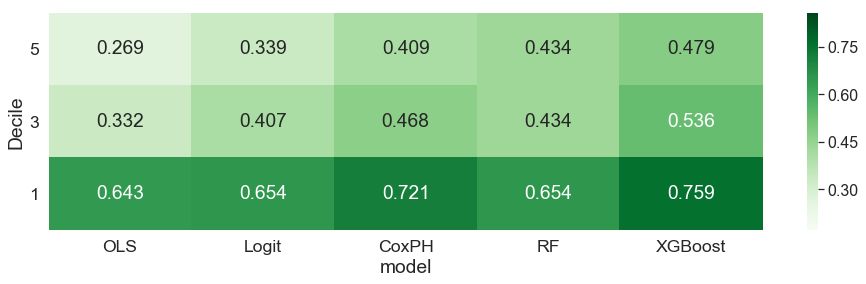

In [9]:
rr_df = pd.DataFrame(new_rr,columns=['model','5th_6th_quantile','overlapping'])
# rr_df.to_csv(output_fpath + "/pred_score_comparison/updated/5th_6th_quantile_overlapping.csv", index=False)
new_rr_df = rr_df.pivot(index='5th_6th_quantile', columns='model', values='overlapping').loc[:,m_list].sort_index(ascending=False)
new_rr_df.index = [int(e) for e in new_rr_df.index*10]
new_rr_df.index.name = "Decile"
vmin = rr_df.iloc[:,2:].get_values().min().min()
vmax = rr_df.iloc[:,2:].get_values().max().max()
l = vmax - vmin
plt.figure(figsize=(16,4))
g = sns.heatmap(new_rr_df,annot=True,fmt=".3g",cmap="Greens",vmin=max(0,vmin-0.2*l),vmax=min(1,vmax+0.2*l))
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.savefig(output_fpath+"/pred_score_comparison/updated/5th_6th_quantile_overlapping_heatmap.png", bbox_inches='tight')
plt.show()